In [1]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
from torch import cuda as cd
import time as timer

In [2]:
def plot_channels(W, name):
    #number of output channels 
    n_out=W.shape[0]
    #number of input channels 
    n_in=W.shape[1]
    w_min=W.min().item()
    w_max=W.max().item()
    fig, axes = plt.subplots(n_out,n_in, figsize=(10,10))
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    out_index=0
    in_index=0
    #plot outputs as rows inputs as columns 
    print(name)
    for ax in axes.flat:

        if in_index>n_in-1:
            out_index=out_index+1
            in_index=0

        ax.imshow(W[out_index,in_index,:,:], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index=in_index+1

    plt.show()

In [3]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [4]:
def plot_activations(A,number_rows= 1,name=""):
    A=A[0,:,:,:].detach().numpy()
    n_activations=A.shape[0]


    print(n_activations)
    A_min=A.min().item()
    A_max=A.max().item()

    if n_activations==1:

        # Plot the image.
        plt.imshow(A[0,:], vmin=A_min, vmax=A_max, cmap='seismic')

    else:
        fig, axes = plt.subplots(number_rows, n_activations//number_rows,figsize=(10,10))
        fig.subplots_adjust(hspace = 3)
        print(name)
        for i,ax in enumerate(axes.flat):
            if i< n_activations:
                # Set the label for the sub-plot.
                ax.set_xlabel( "activation:{0}".format(i+1))

                # Plot the image.
                ax.imshow(A[i,:], vmin=A_min, vmax=A_max, cmap='seismic')
                ax.set_xticks([])
                ax.set_yticks([])
    plt.show()

In [5]:
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows, figsize=(10,10))
    fig.subplots_adjust(hspace=3,wspace=1)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)
    plt.show()

In [6]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

In [7]:
def train_model(model, optimizer, criterion, train_loader, validation_loader, validation_dataset, n_epochs=10, use_cuda=True):
    
    #if use_cuda:
        
    #global variable 
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)

    return accuracy_list, loss_list

In [8]:
class CNN_batch(nn.Module):

    # Contructor
    def __init__(self, out_1=16, out_2=32, out_3=64,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=5, stride=1, padding=2)
        self.conv3_bn = nn.BatchNorm2d(out_3)

        self.maxpool3=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(out_3*4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x

    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out0 = self.maxpool1(a1)

        z2 = self.cnn2(out0)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)

        z3 = self.cnn3(out1)
        a3 = torch.relu(z3)
        out2 = self.maxpool3(a3)
        
        out = out0.view(out0.size(0),-1)
        return z1, a1, z2, a2, z3, a3, out0, out1, out2, out

In [9]:
model_CNN_BATCH = CNN_batch()
print(model_CNN_BATCH)

CNN_batch(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (bn_fc1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [10]:
out=conv_output_shape((16,16), kernel_size=5, stride=1, pad=2, dilation=1)
print('Image size after first convolution:',out)
out1=conv_output_shape(out, kernel_size=5, stride=1, pad=2, dilation=1)
print('Image size after second convolution:',out1)
out2=conv_output_shape(out1, kernel_size=5, stride=1, pad=2, dilation=1)
print('Image size after third convolution:',out2)

Image size after first convolution: (16, 16)
Image size after second convolution: (16, 16)
Image size after third convolution: (16, 16)


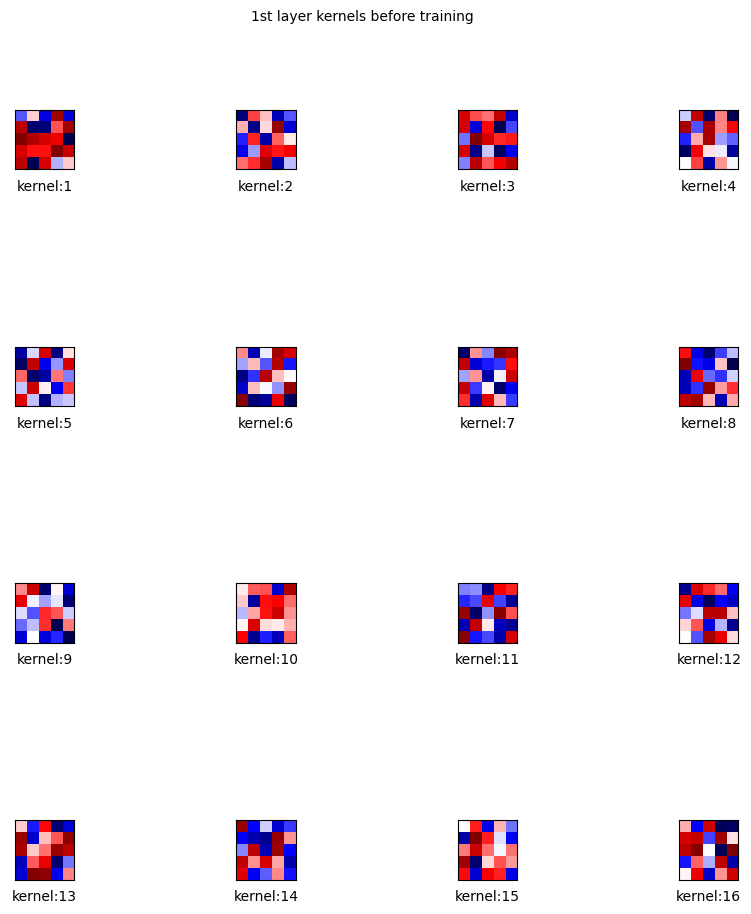

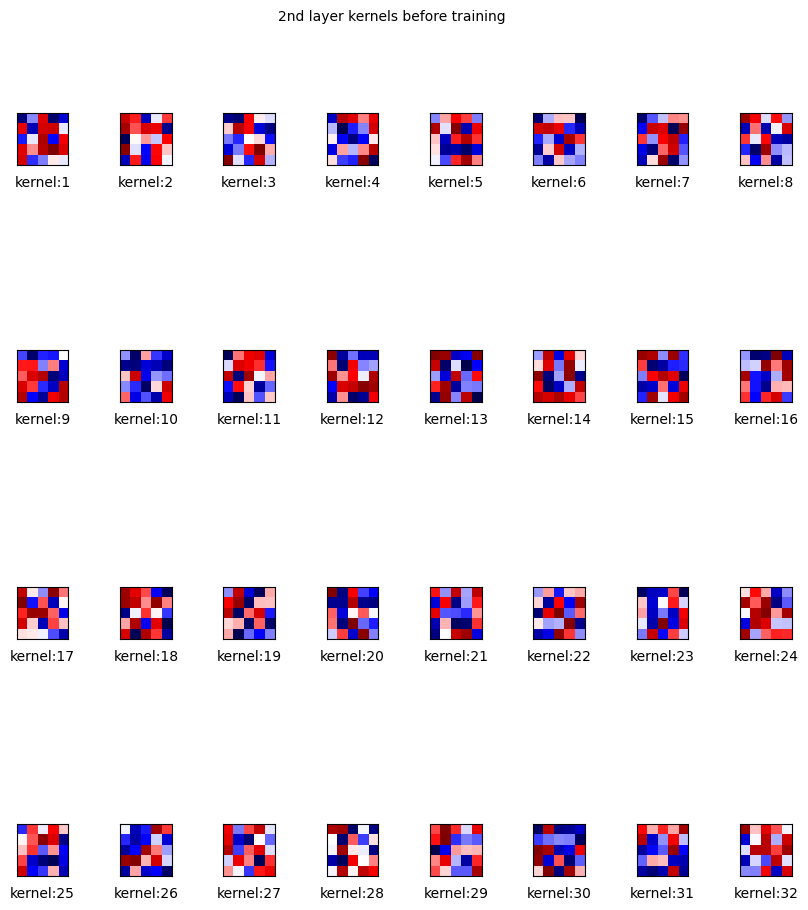

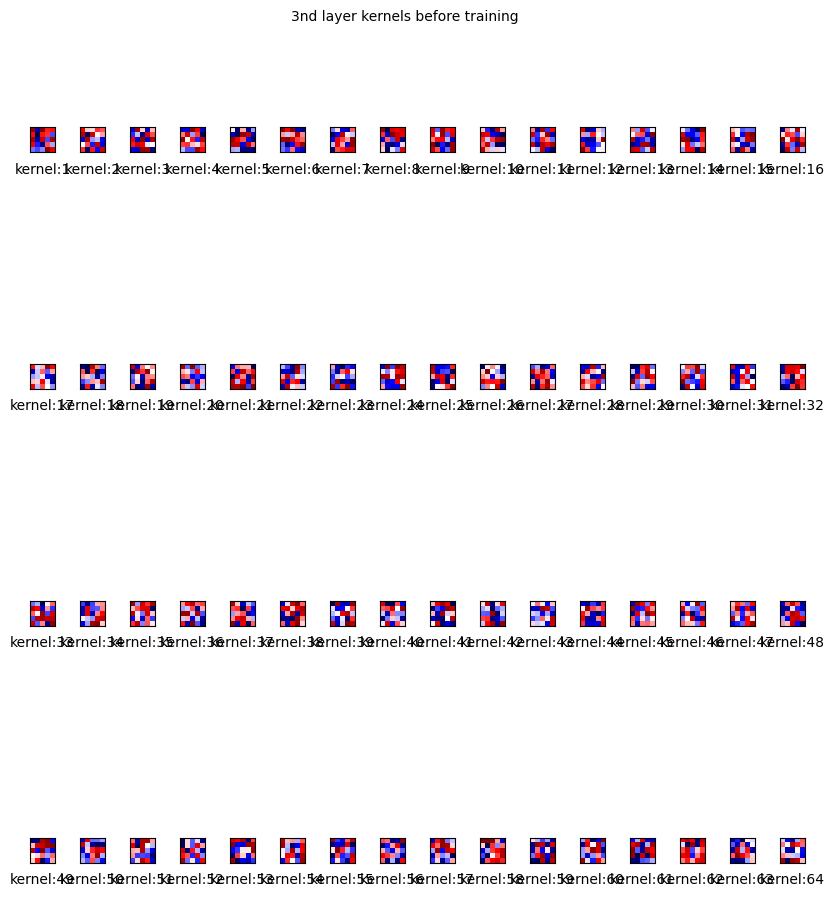

In [11]:
plot_parameters(model_CNN_BATCH.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model_CNN_BATCH.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )
plot_parameters(model_CNN_BATCH.state_dict()['cnn3.weight'], number_rows=4, name='3nd layer kernels before training' )

In [12]:
IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [13]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [14]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.Adam(model_CNN_BATCH.parameters(), lr = learning_rate)

accuracy_list_batch, loss_list_batch=train_model(model=model_CNN_BATCH,
                                                 n_epochs=10,
                                                 train_loader=train_loader,
                                                 validation_loader=validation_loader,
                                                 validation_dataset=validation_dataset,
                                                 optimizer=optimizer,
                                                 criterion=criterion)

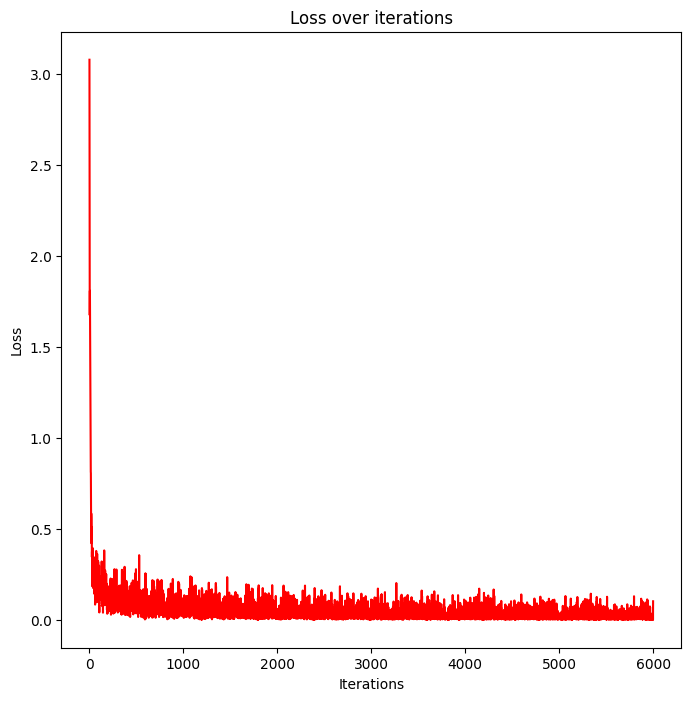

In [15]:
plt.figure(figsize=(8, 8))
plt.plot(loss_list_batch, color='red', label='Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

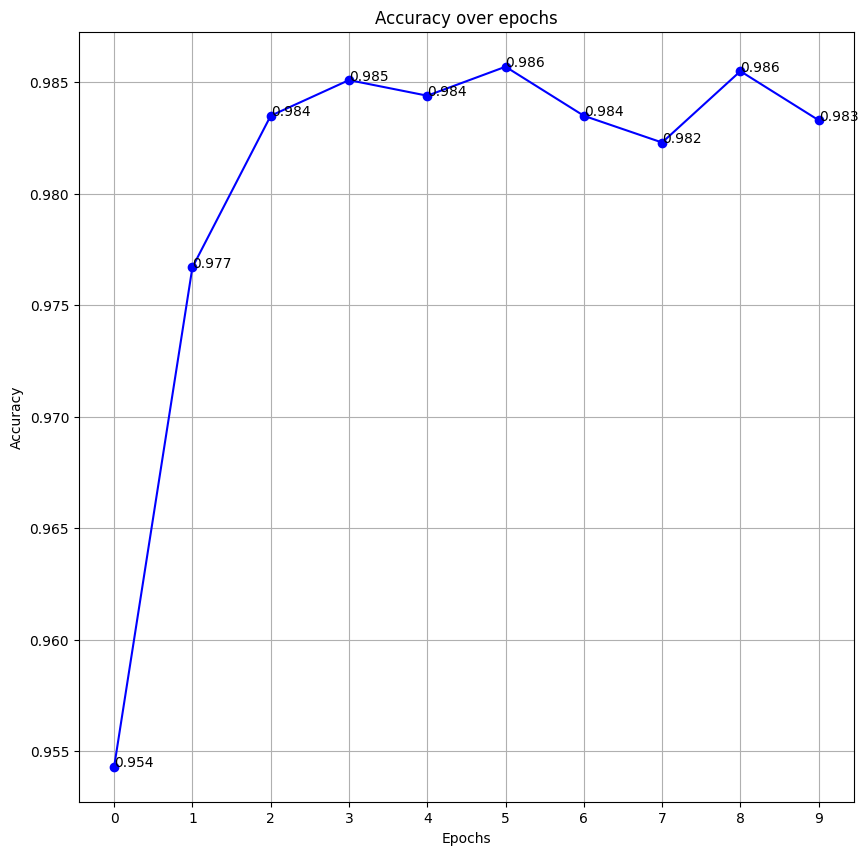

In [16]:
plt.figure(figsize=(10, 10))
plt.plot(accuracy_list_batch,'bo-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.xticks(np.arange(0, len(accuracy_list_batch)))
plt.grid()
for i,j in enumerate(accuracy_list_batch):
    plt.text(i,j,np.round(j,3))
plt.show()

Convolution 1 wights


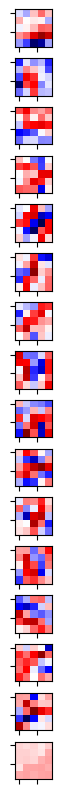

Convolution 2 wights


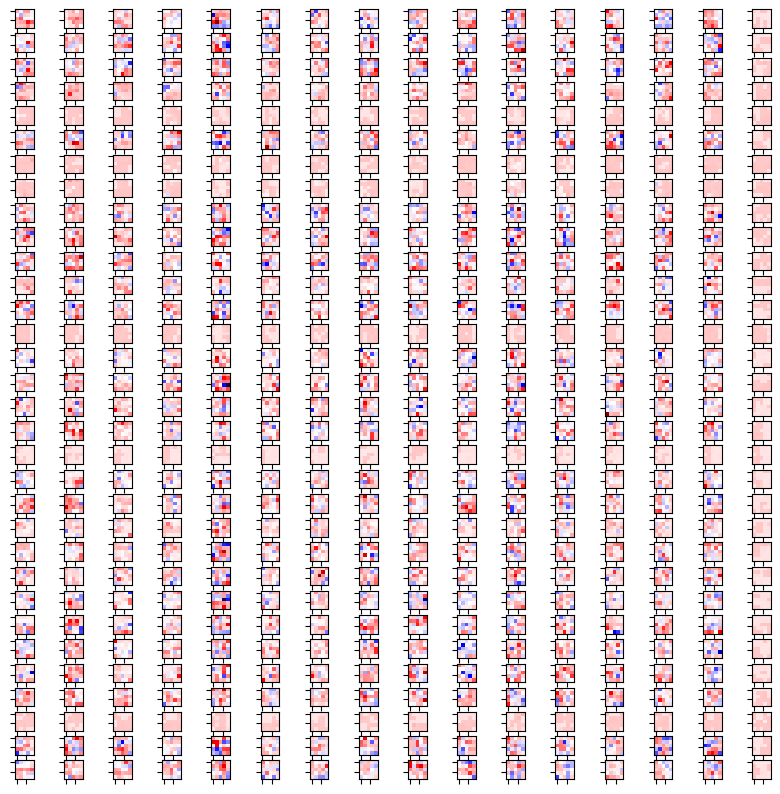

Convolution 3 wights


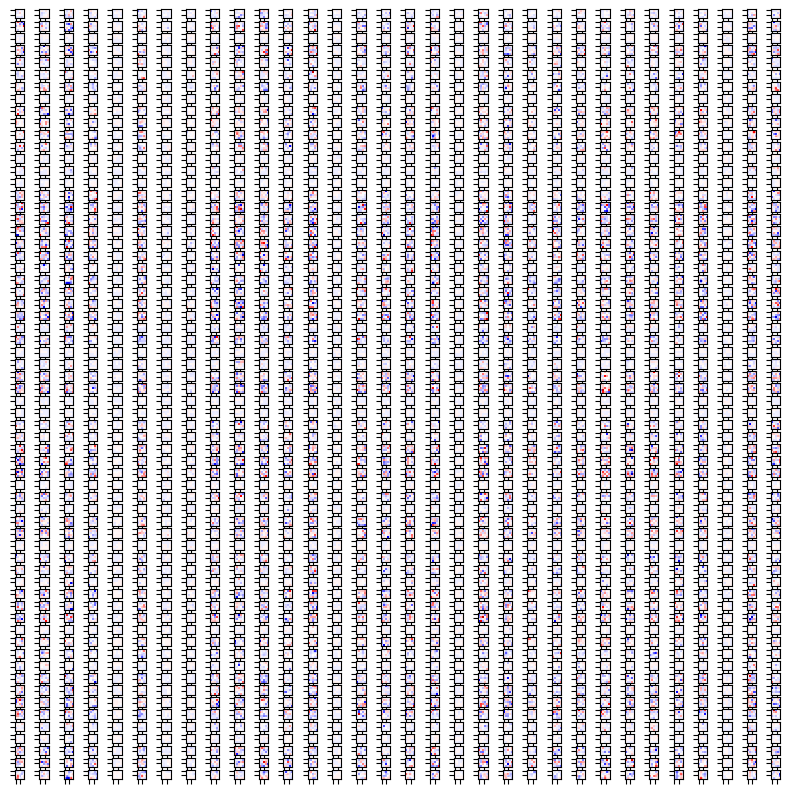

In [17]:
plot_channels(model_CNN_BATCH.state_dict()['cnn1.weight'],name='Convolution 1 wights')
plot_channels(model_CNN_BATCH.state_dict()['cnn2.weight'],name='Convolution 2 wights')
plot_channels(model_CNN_BATCH.state_dict()['cnn3.weight'],name='Convolution 3 wights')

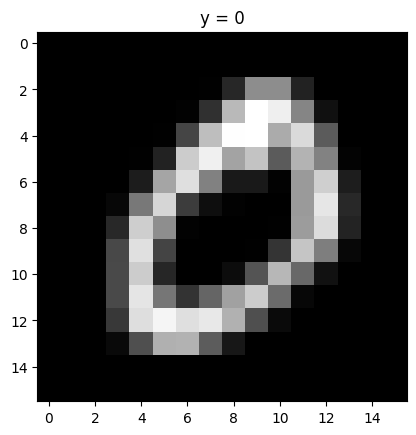

In [18]:
show_data(train_dataset[1])
out = model_CNN_BATCH.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))


16
Output after the 1st CNN


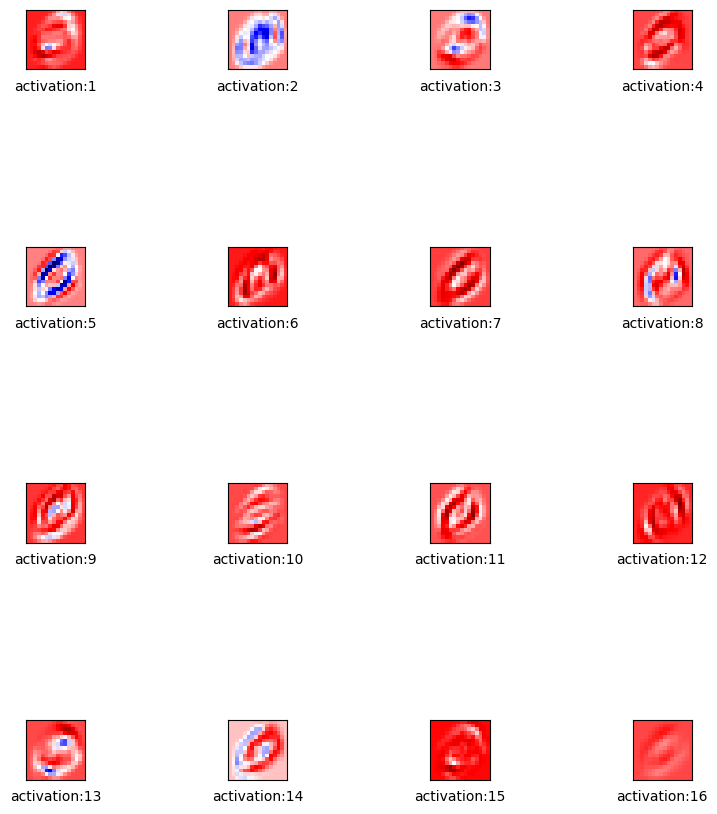

16
Output after the 1st Relu


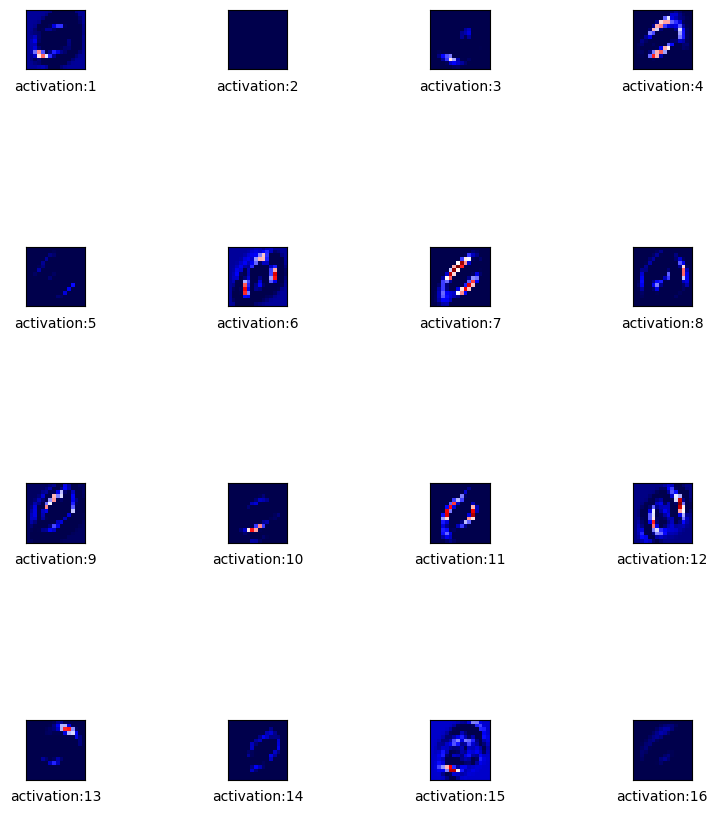

32
Output after the 2nd CNN


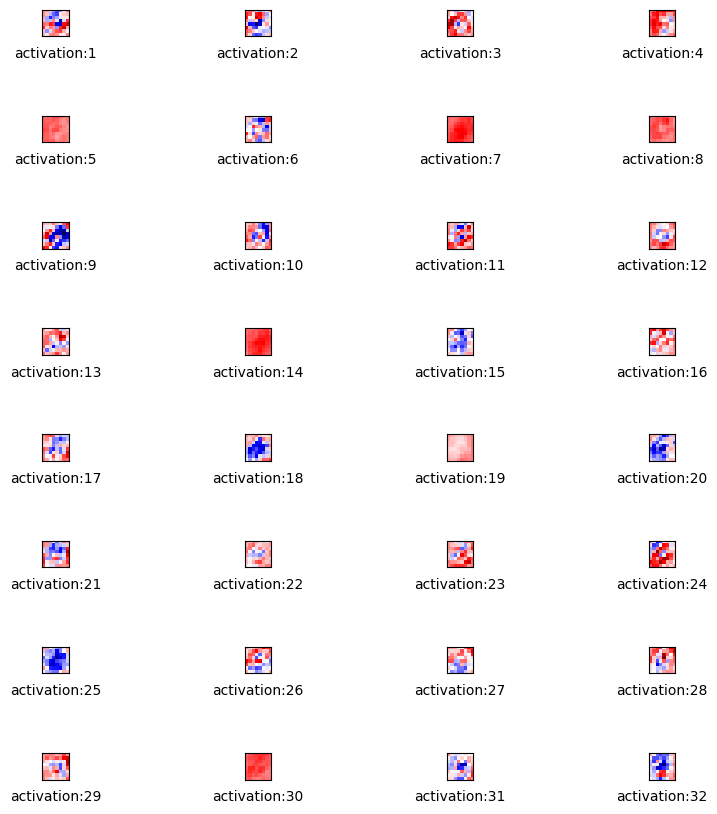

32
Output after the 2nd Relu


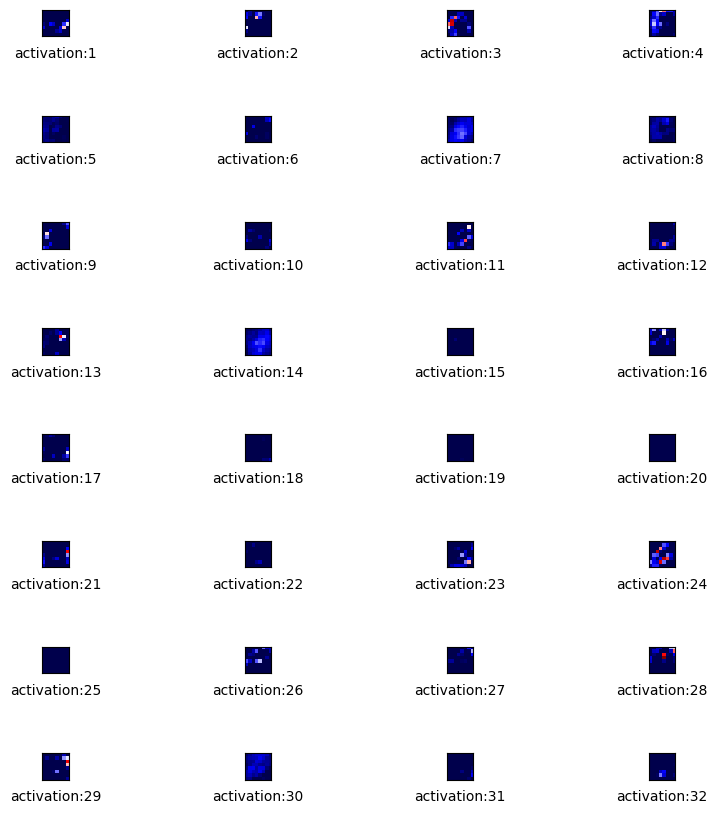

64
Output after the 3nd CNN


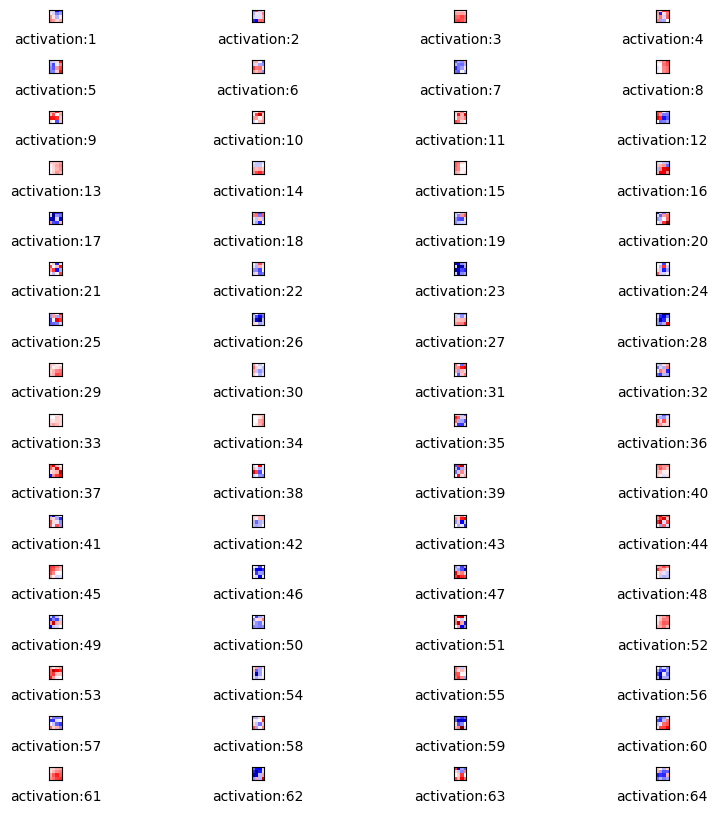

64
Output after the 3nd Relu


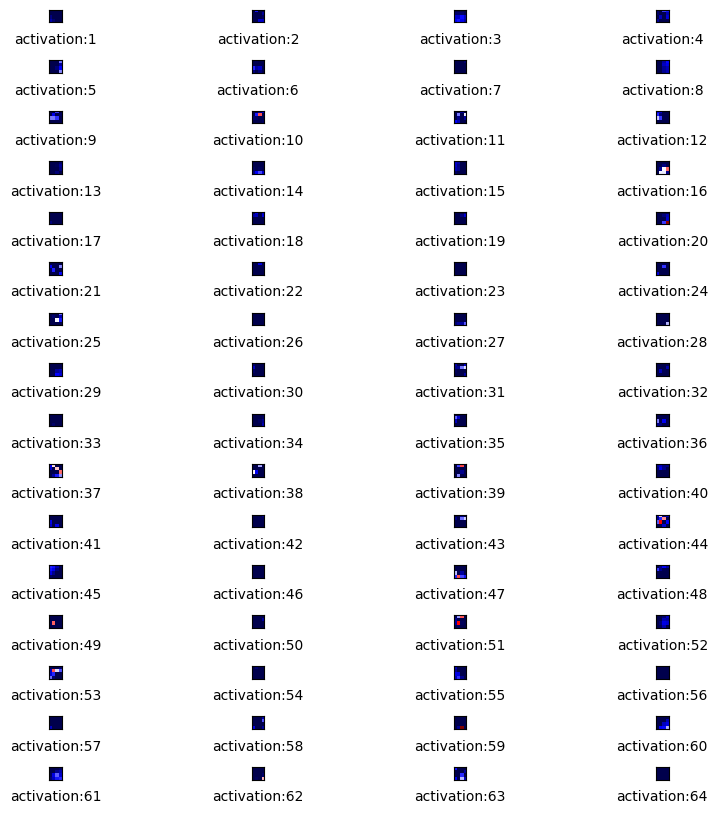

In [19]:
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")
plot_activations(out[2], number_rows=32//4, name="Output after the 2nd CNN")
plot_activations(out[3], number_rows=32//4, name="Output after the 2nd Relu")
plot_activations(out[4], number_rows=64//4, name="Output after the 3nd CNN")
plot_activations(out[5], number_rows=64//4, name="Output after the 3nd Relu")

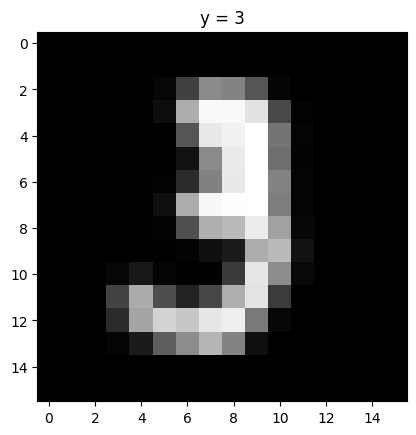

In [20]:
show_data(train_dataset[10])
out_1 = model_CNN_BATCH.activations(train_dataset[10][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))


16
Output after the 1st CNN


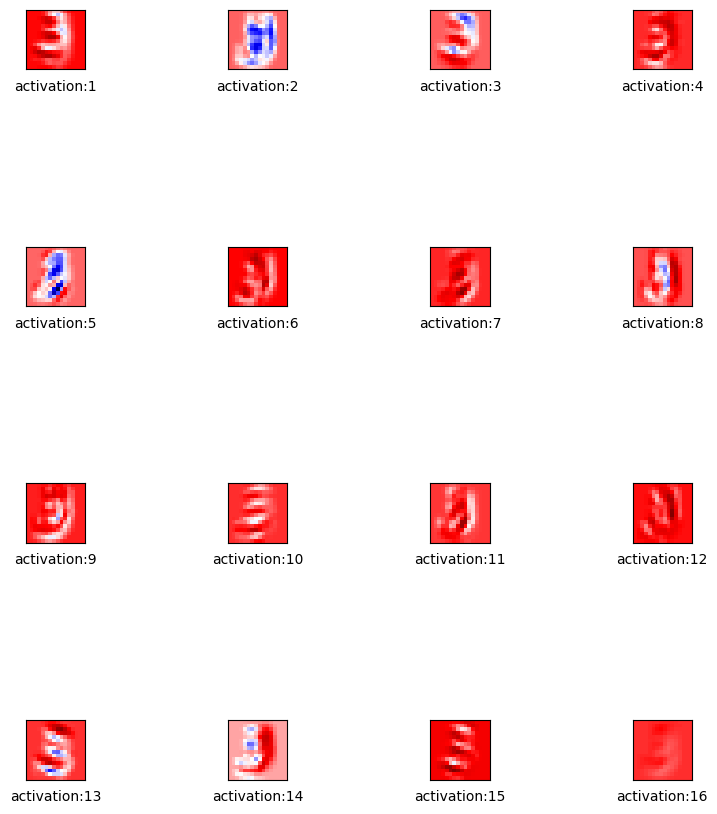

16
Output after the 1st Relu


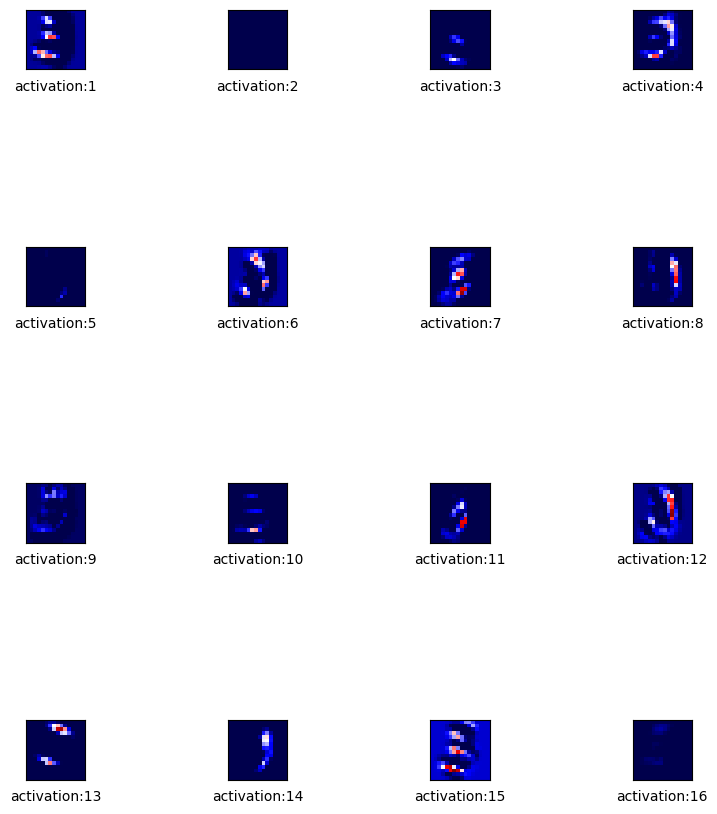

32
Output after the 2nd CNN


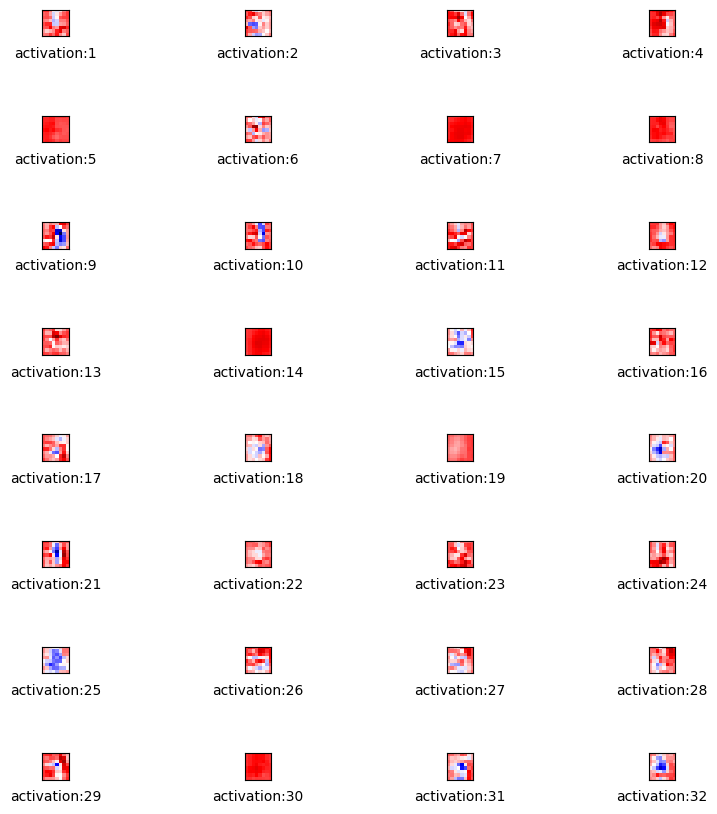

32
Output after the 2nd Relu


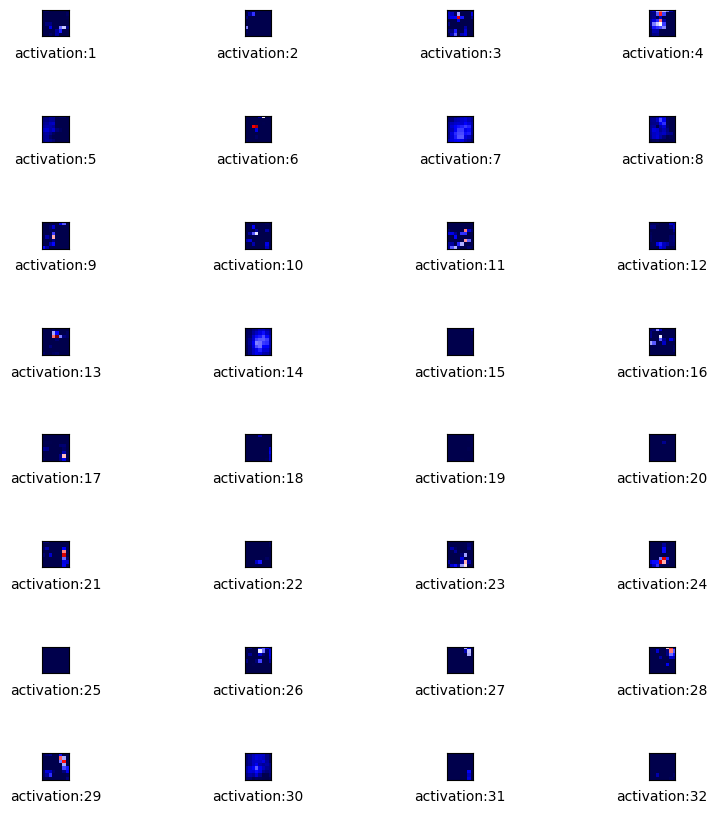

64
Output after the 3nd CNN


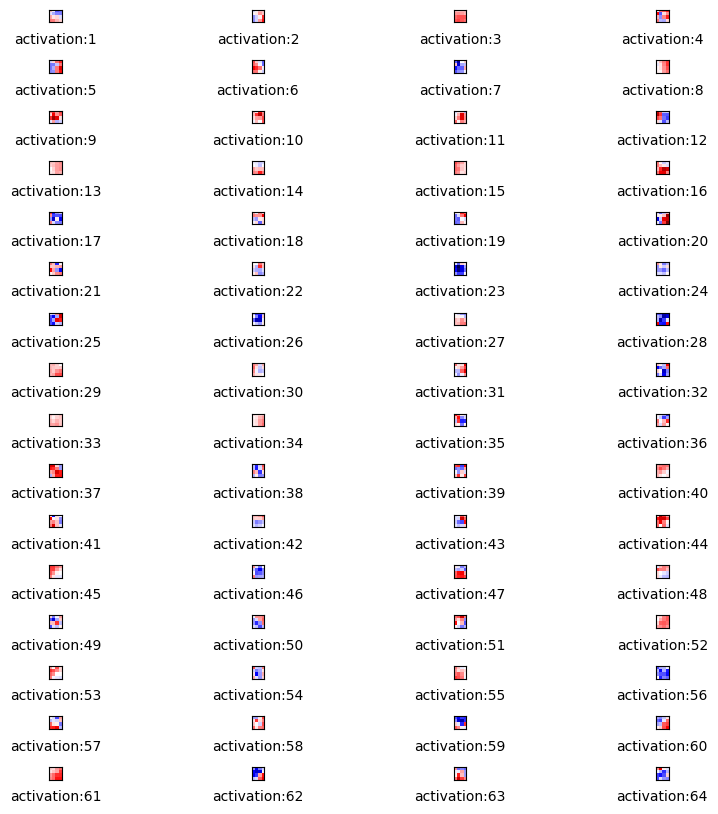

64
Output after the 3nd Relu


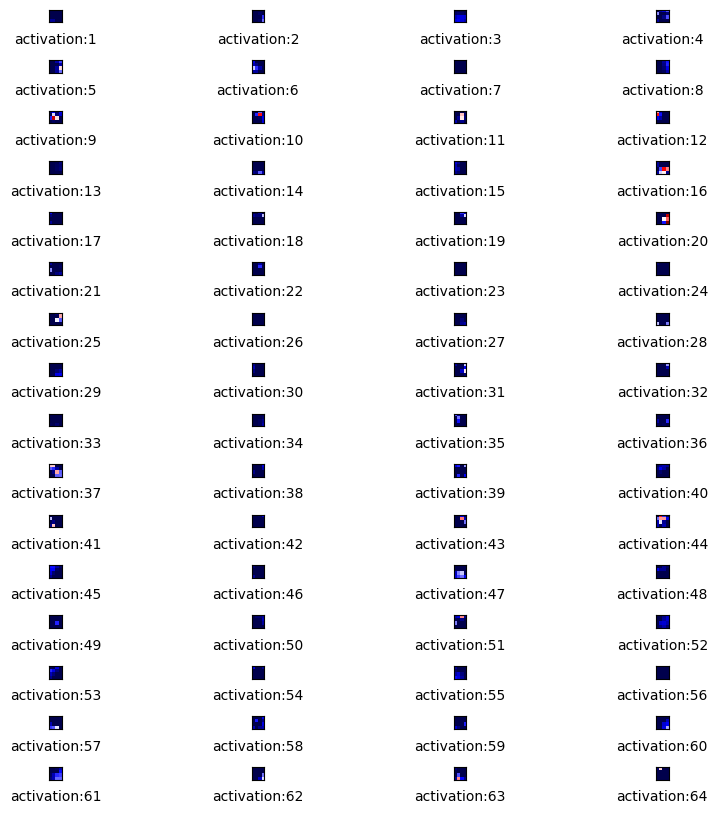

In [21]:
plot_activations(out_1[0], number_rows=4, name="Output after the 1st CNN")
plot_activations(out_1[1], number_rows=4, name="Output after the 1st Relu")
plot_activations(out_1[2], number_rows=32//4, name="Output after the 2nd CNN")
plot_activations(out_1[3], number_rows=32//4, name="Output after the 2nd Relu")
plot_activations(out_1[4], number_rows=64//4, name="Output after the 3nd CNN")
plot_activations(out_1[5], number_rows=64//4, name="Output after the 3nd Relu")

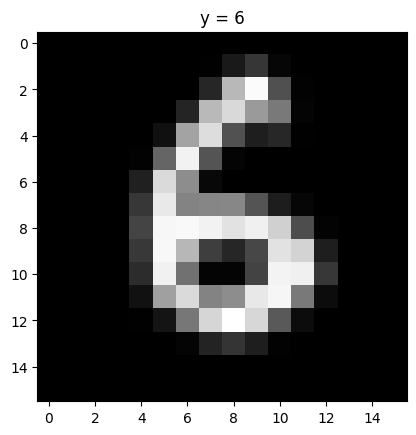

In [22]:
show_data(train_dataset[106])
out_2 = model_CNN_BATCH.activations(train_dataset[10][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

16
Output after the 1st CNN


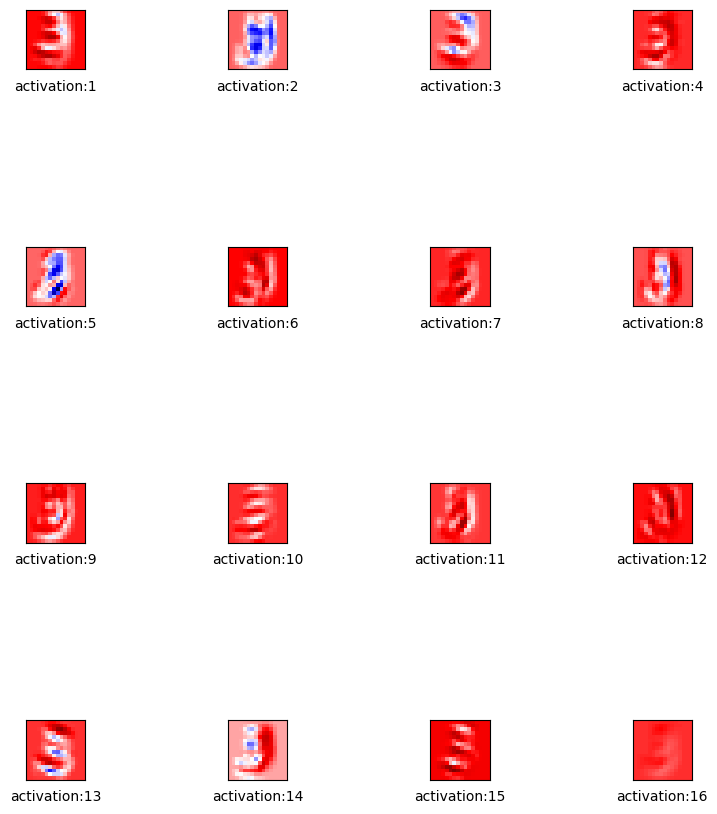

16
Output after the 1st Relu


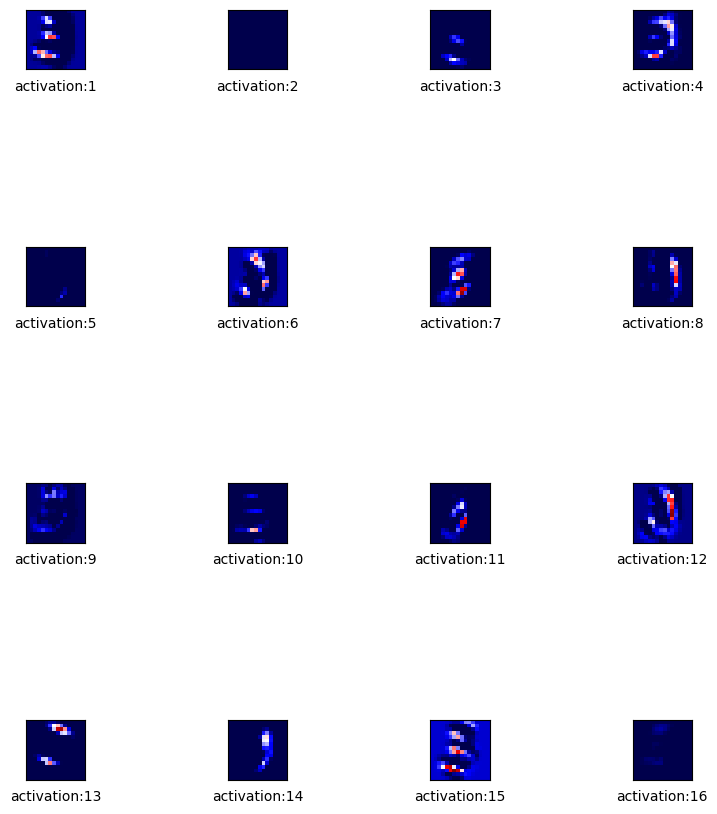

32
Output after the 2nd CNN


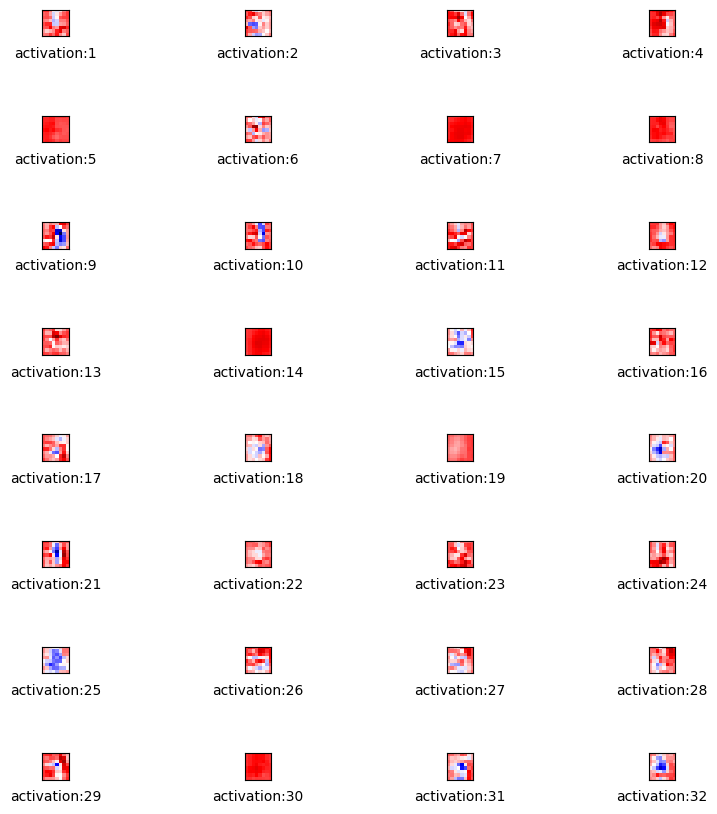

32
Output after the 2nd Relu


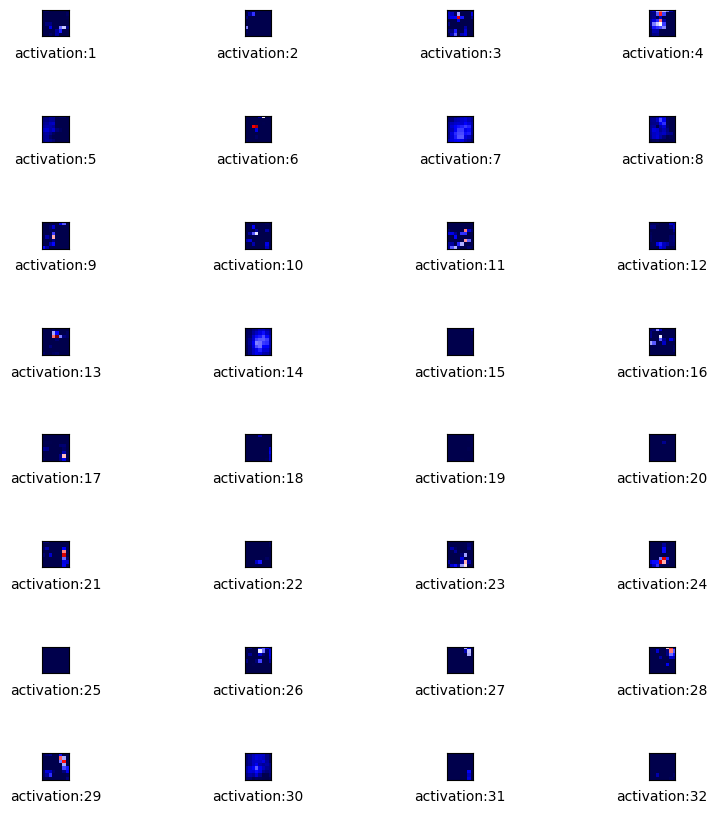

64
Output after the 3nd CNN


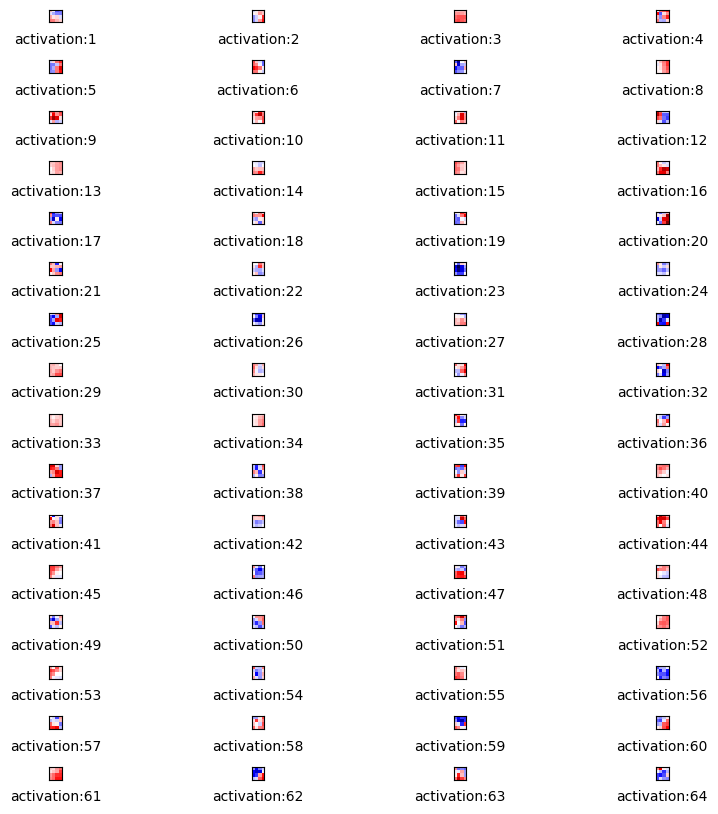

64
Output after the 3nd Relu


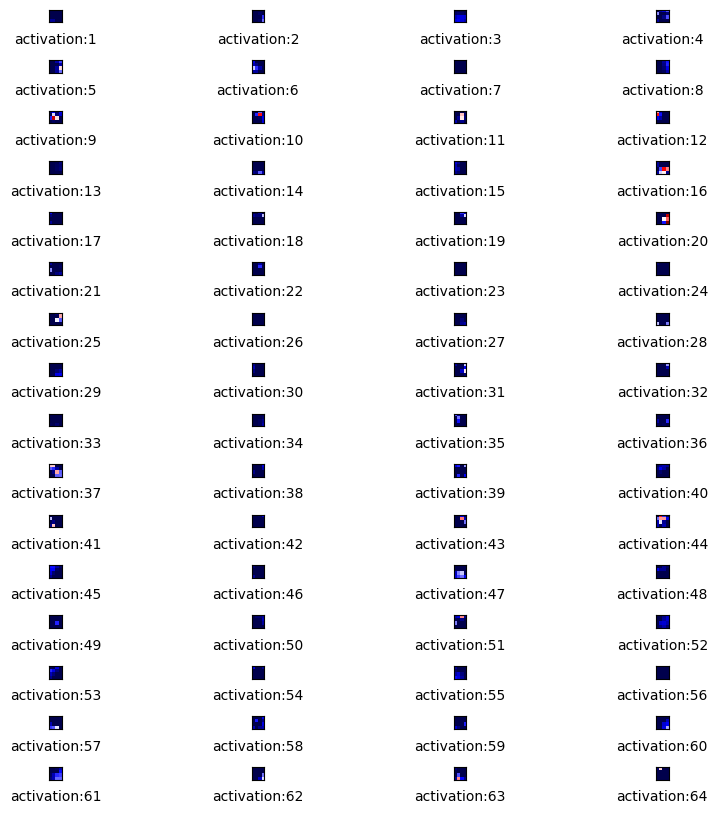

In [23]:
plot_activations(out_2[0], number_rows=4, name="Output after the 1st CNN")
plot_activations(out_2[1], number_rows=4, name="Output after the 1st Relu")
plot_activations(out_2[2], number_rows=32//4, name="Output after the 2nd CNN")
plot_activations(out_2[3], number_rows=32//4, name="Output after the 2nd Relu")
plot_activations(out_2[4], number_rows=64//4, name="Output after the 3nd CNN")
plot_activations(out_2[5], number_rows=64//4, name="Output after the 3nd Relu")

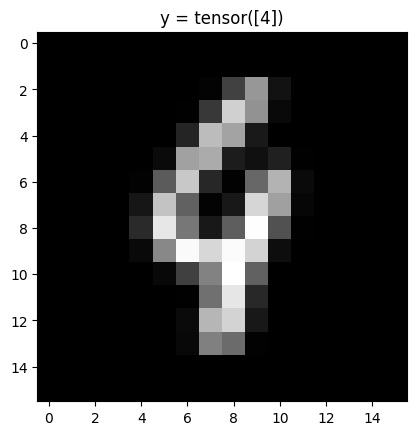

yhat:  tensor([9])


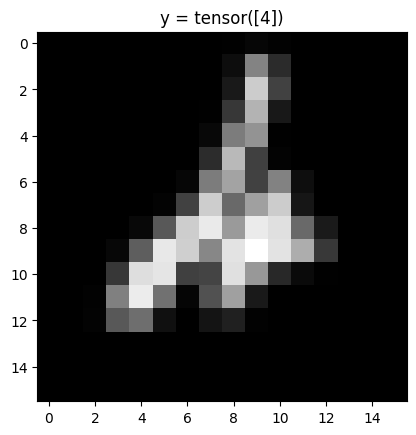

yhat:  tensor([2])


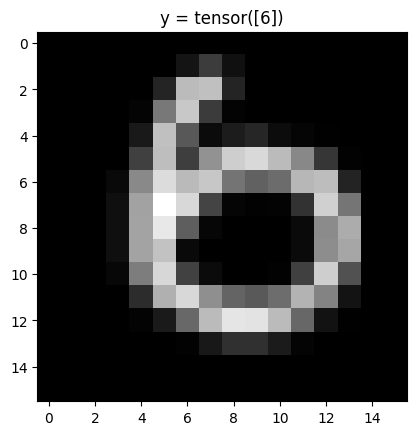

yhat:  tensor([0])


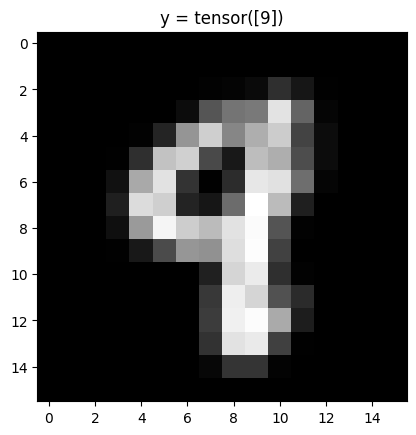

yhat:  tensor([4])


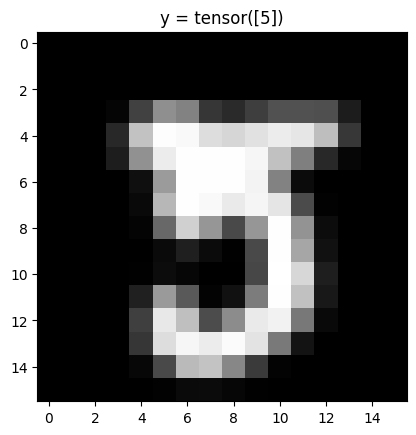

yhat:  tensor([3])


In [24]:
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model_CNN_BATCH(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  